In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import gym

import seaborn as sns

import time

from collections import defaultdict

from IPython import display
from IPython.display import clear_output

# Environment preparation
In this example the [gym tool](https://gym.openai.com) is used to create a simulation environment in which an agent needs to learn a task. The environment used is called 'Taxi-v3'. In this toy environment the agents needs to drive a taxi to pick up and drop passengers. 

> There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions. (['Taxi-v3'](https://gym.openai.com/envs/Taxi-v3/))

In [3]:
# import and create the simulation environment
import gym
env = gym.make("Taxi-v3")

print("Number of actions : {}".format(env.action_space))
print("Number of states  : {}".format(env.observation_space))

initial_state = env.reset()
print("Initial state     : {}".format(initial_state))

Number of actions : Discrete(6)
Number of states  : Discrete(500)
Initial state     : 274


In [4]:
# render environment
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Running an episode
Below we define a function to run one episode.

In [5]:
# Define loop for one episode
def run_episode(env, agent, train=True, max_steps=100_000, render=False, sleep=.1):
    done = False
    score = 0
    steps = 0
    start_timer = time.time()

    obs = env.reset()

    while (not done) and (steps < max_steps):
        # get action from the agent
        action = agent.compute_action(obs)

        # advance one step in the environment
        next_obs, reward, done, info = env.step(action)

        # update score
        score += reward


        if train:
            # save the transition
            agent.update(obs, action, reward, done, next_obs)

        # update current state
        obs = next_obs

        steps += 1
        
        if render:
            time.sleep(sleep)
            clear_output(wait=True)
            env.render()

    # Call to clear internal agent statistics (reward, return, etc.)
    agent.finalize_episode()

    total_time = time.time() - start_timer
    return {
        "score": score,
        "steps_per_game": steps,
        "framerate": steps / (total_time + 1e-6),
        "time_per_game": total_time,
    }


Lets define an abstract agent class that implements all neccessary methods.

In [6]:
class Agent:
    """
    Interface for the agent class
    """

    def compute_action(self, obs):
        ...

    def update(self, *args, **kwargs):
        ...

    def finalize_episode(self, *args, **kwargs):
        ...

## Baseline: Random Agent

For testing our environment we are going to use a random agent.

In [8]:
class RandomAgent(Agent):
    def __init__(self, n_actions):
        self.n_actions = n_actions
    
    def compute_action(self, obs):
        return np.random.randint(self.n_actions)

In [9]:
env = gym.make("Taxi-v3")

n_actions = env.action_space.n
random_agent = RandomAgent(n_actions)

In [10]:
run_episode(env, random_agent, render=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


{'score': -821,
 'steps_per_game': 200,
 'framerate': 9.169012028454627,
 'time_per_game': 21.812599897384644}

It is also convenient to define a method to run several episodes in a row and plot some statistics.

In [12]:
# Define loop for multiple episodes
def run_experiment(
    env,
    agent,
    runs=100,
    x_plot=None,
    plot_stats=None,
    history=defaultdict(list),
    update_plot_period=1,
    **kwargs,
):

    total_steps = 0
    
    # Initialize plots
    if plot_stats:
        num_plots = len(plot_stats)
        fig, axs = plt.subplots(num_plots, 1, squeeze=False, figsize=(10, 5 * num_plots))
        axs = axs.ravel()
    
    for i in range(runs):
        # Run an episode
        stats = run_episode(env, agent, **kwargs)

        # Update history object
        for k, v in stats.items():
            if k not in history.keys():
                history[k] = []
            history[k].append(v)
            
        # record total steps per game
        total_steps += history["steps_per_game"][-1]
        history["total_steps"].append(total_steps)
        
        # plot statistics if neccessary
        if plot_stats:
            if i % update_plot_period == 0:
                for ax, stat_name in zip(axs, plot_stats):
                    ax.clear()
                    if x_plot is None:
                        sns.lineplot(
                            x=np.arange(len(history[stat_name])), y=history[stat_name], ax=ax
                        )
                    else:
                        sns.lineplot(x=history[x_plot], y=history[stat_name], ax=ax)
                    ax.set_title(stat_name)
                display.display(fig)
                display.clear_output(wait=True)
        else:
            ...
            print(f"episode {i}/{runs} | {stats}", )

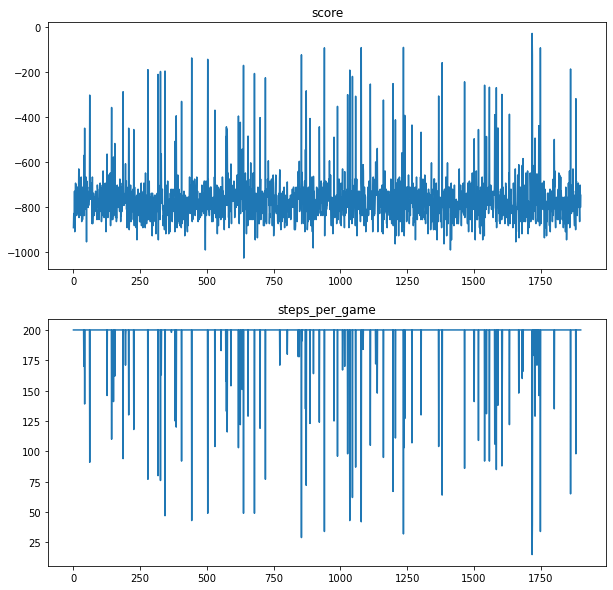

In [13]:
run_experiment(
    env,
    random_agent,
    runs=2000,
    plot_stats=['score', 'steps_per_game'],
    update_plot_period=100
)

Random agent is not doing so well. But if we look at the "steps_per_game" we can see that sometimes it is able to successfully deliver a passanger. 

In RL it is important to set a baseline, so you can clearly see when you made an improvement. Random agent is a good baseline to start with.

Lets try and improve it by using Tabular Q-learning algorithm.

# Build Q-learning Agent
In the masterclass we have explaiuned how the Q-learning algorithm is working. Following this methods, an agent learns to evaluate a state-action combinations.

To build your own agent you will need to implement an update rule:

$$
Q(S_t,A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} +\gamma \max\limits_{a} Q(S_{t+1},a) - Q(S_t,A_t) \right]
$$

And exploitation rule:
$$ 
A_t = \operatorname{argmax}_a Q(S_t, a)
$$

In [11]:
class QAgent:
    def __init__(
        self, n_states, n_actions, epsilon=0.2, alpha=0.1, gamma=0.9):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

        self.n_actions = n_actions
        self.n_states = n_states

        self.q_table = np.zeros((self.n_states, self.n_actions), np.float)

    def finalize_episode(self):
        self.sum_rewards = 0
        self.return_ = 0

    def compute_action(self, obs):
        # explore take a random action with p=epsilon
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else: # exploit
            #---YOUR CODE HERE---#
            ...
        
        return action

    def update(self, obs, action, reward, done, next_obs):
        #---YOUR CODE HERE---#
        ...
        

Once you are finished filling the blanks, you can test your agent in the next cells.

In [12]:
env = gym.make("Taxi-v3")

n_states = env.observation_space.n
n_actions = env.action_space.n

agent = QAgent(n_states, n_actions, epsilon=0.1, alpha=0.1, gamma=0.99,)

# create history dictionary so that you continue training and save the results
history = defaultdict(list) 

In [ ]:
run_experiment(
    env,
    agent,
    runs=2000,
    x_plot=None,
    plot_stats=['score', 'steps_per_game', 'total_steps'],
    update_plot_period=100,
    history=history)

In [ ]:
run_episode(env, agent, render=True)